In [1]:
from functools import reduce
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import xlrd
import datetime
import seaborn as sn
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMAResults 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
import pickle

In [2]:
data_location = 'sqlite:///../../data/data.db'
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)

## 0. Functions

In [3]:
def rmse(y,yprime):
    return np.sqrt(mean_squared_error(y,yprime))

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

## I. Data processing

In [4]:
tokens = ohlc.token.unique()

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

###### We now have a processed dataframe, and we can run our models and beat the class model

#### Definition of y - we wanna predict the hourly returns for SOL

In [5]:
y = X.ret_SOL.shift(-1)[:-1] # Because we wanna predict one step further
X = X[:-1]

y = y[1:]
X = X[1:]

###### From the study performed in class, we know those nulls values come from the first value of each return serie. We will therefore analyze X[1:] and y[1:] to get rid of those issues.

###### We will know look at the correlations between variables. We should see the same results than in class : the correlation with each of the column should be really weak.

In [6]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.03222676521764845,
 'ret_BTC': -0.013848623804147264,
 'vol_ETH': 0.02831278607222288,
 'ret_ETH': 0.030649212659338235,
 'vol_USDT': 0.008052452096205165,
 'ret_USDT': -0.04440085499052747,
 'vol_SOL': 0.04005280885760558,
 'ret_SOL': -0.029855064193406493,
 'vol_ADA': 0.04312933662506508,
 'ret_ADA': 0.00024928333961421933,
 'vol_DOT': 0.06358776489448076,
 'ret_DOT': 0.008193946995455033,
 'vol_AVAX': 0.04720505727224018,
 'ret_AVAX': 0.016919450289767074,
 'vol_ATOM': 0.0015190192889454235,
 'ret_ATOM': 0.05546161881659775,
 'vol_CRV': 0.024606382287312822,
 'ret_CRV': -0.005844145396121416,
 'vol_AAVE': 0.040053045174672994,
 'ret_AAVE': 0.01989568673206621,
 'vol_COMP': 0.06439534601970955,
 'ret_COMP': 0.02011314149015308}

###### Same results than in class.

----

## 2. Features importance study : random forest test

###### As we have seen previously, the correlation on a column to column basis is weak. However, this correlation is distributed inhomogeneously through the different columns. I guess those for which the correlation is closer to 0 than the other ones are creating a noise that is running our results down. What I will do now is selecting the n features which are the most relevant to explain the values of y, n given for now. 
###### Note : we will then compare those results with a PCA study.

In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
plt.style.use('dark_background')

# Note : you might have to upgradde scikit-learn to import permutation_importance

In [8]:
test_size = 0.2 #use 20% of the data set for validation in you cross-validation

###### We will evaluate features importance on (X_train, y_train). 

In [9]:
y_train = y[:int( (1-test_size)*len(y) )]
X_train = X[: int( (1-test_size) * len(X) ) ]

y_test = y[int( (1-test_size)*len(y) ):]
X_test = X[int( (1-test_size) * len(X) ) :]

In [10]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train) # to get rid of the NaN

RandomForestRegressor(n_estimators=150)

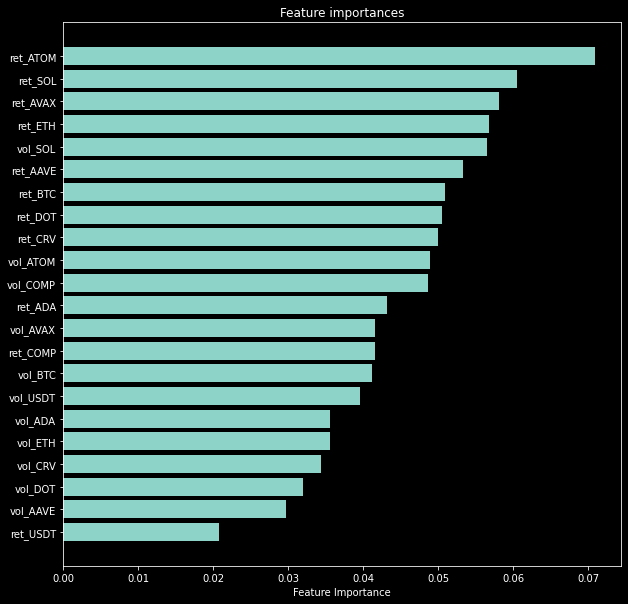

In [11]:
plt.figure(figsize = (10,10))
sort = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.title('Feature importances')
plt.show()

###### The feature with the higher importance is the ts containing hourly returns of ATOM. Yet, its importance is <<1. Thus, as a first test, we will try to build an autoregressive model.   

## 3. First model : basic forecast, autoregressive model

Text(0.5, 1.0, 'Hourly returns, ALO')

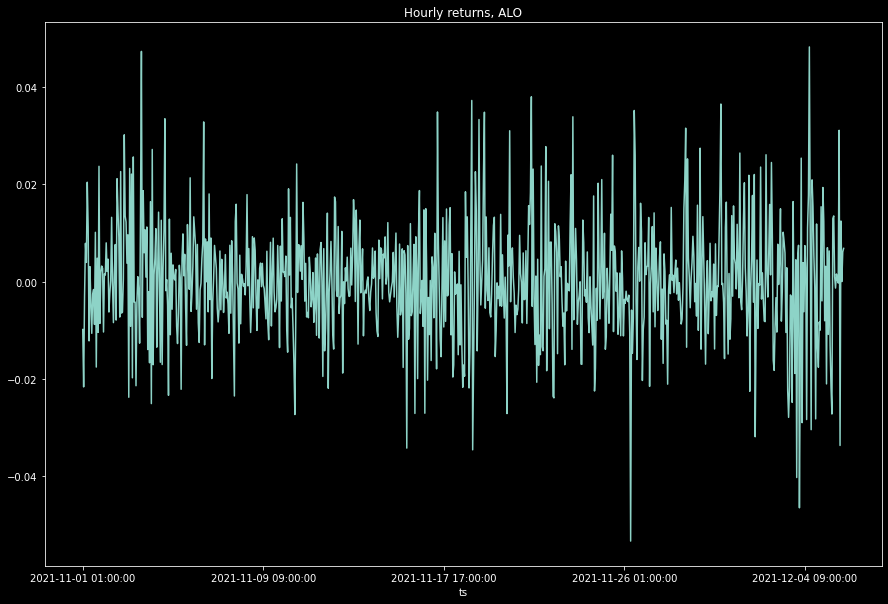

In [12]:
plt.figure(figsize = (15,10))
y_train.plot()
plt.title('Hourly returns, ALO')

###### We can see here that the time serie look stationnary - we will verify it via a stationarity test right below. 

### 3. 1. Stationnarity test

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

P-value:  0.0


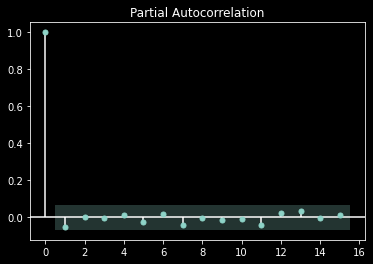

In [14]:
df_stationarityTest = adfuller(y_train, autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(y_train, lags=15)

###### This time serie can be considered as stationnary with a p-value < 0.01. We will now run a forecast based on autoregressive models. 

### 3. 2. Autoregressive model - AR and ARIMA model

#### 3. 2. a. AR model

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  844
Model:                     AutoReg(1)   Log Likelihood                2518.769
Method:               Conditional MLE   S.D. of innovations              0.012
Date:                Thu, 20 Jan 2022   AIC                             -8.806
Time:                        19:43:48   BIC                             -8.790
Sample:                             1   HQIC                            -8.800
                                  844                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.339e-06      0.000      0.017      0.986      -0.001       0.001
y.L1          -0.0495      0.034     -1.439      0.150      -0.117       0.018
                                    Roots           

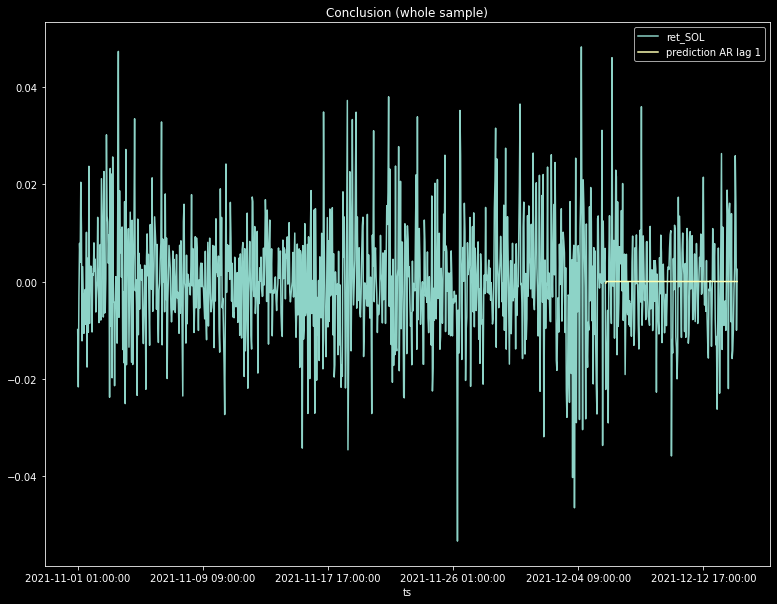

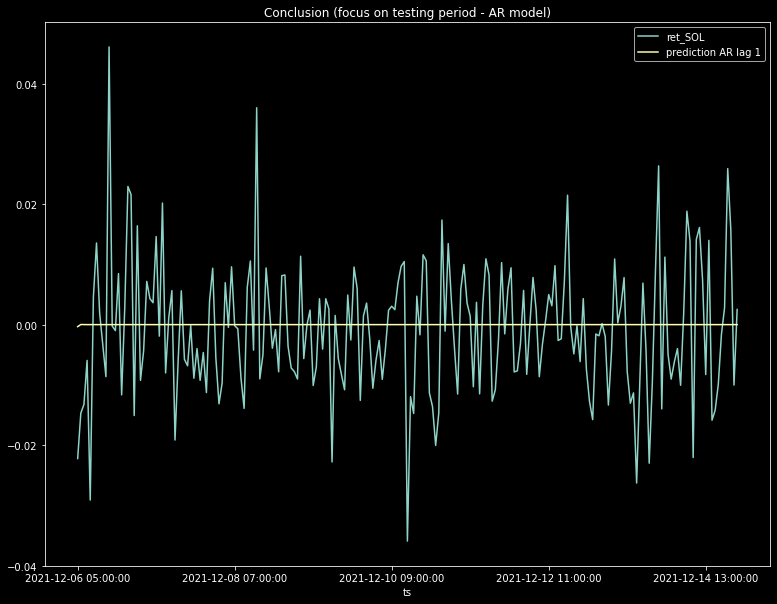

RMSE (without cross-validation) :0.011032821238110689


In [15]:
ar_model = AutoReg(y_train.values, lags=1).fit()
print(ar_model.summary())
pred = ar_model.predict(start=len(y_train), end=(len(y)-1), dynamic=False)

df_conclu = pd.merge(pd.DataFrame(y), pd.DataFrame(pred, index = y_test.index, 
                                          columns = ['prediction AR lag 1']), how = 'left',
                     left_index = True, right_index = True)
df_conclu.plot(figsize = (13,10))
plt.title('Conclusion (whole sample)')
plt.show()

df_conclu.loc[y_test.index].plot(figsize = (13,10))
plt.title('Conclusion (focus on testing period - AR model)')
plt.show()

print('RMSE (without cross-validation) :'+str(rmse(pred, y_test.values)))

#### 3. 2. b. ARIMA model - integrated moving average

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5035.855, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5037.788, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5037.856, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5037.837, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5039.788, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.771 seconds


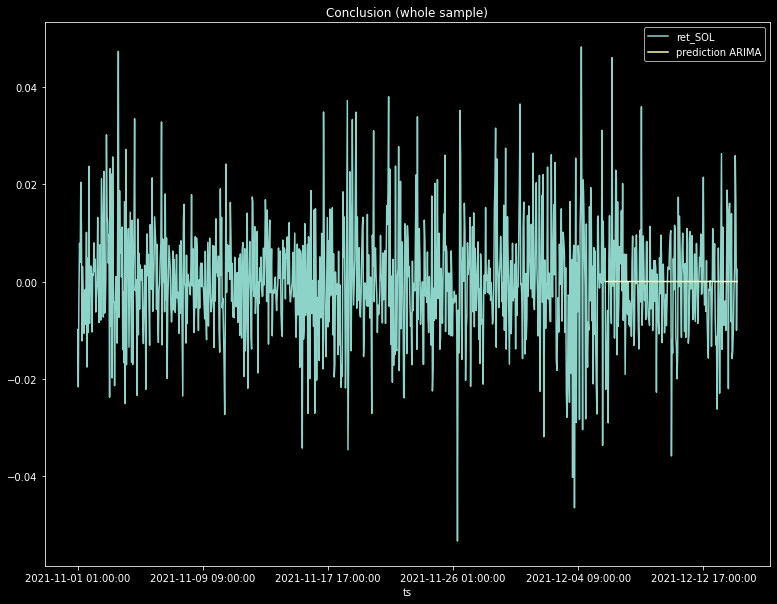

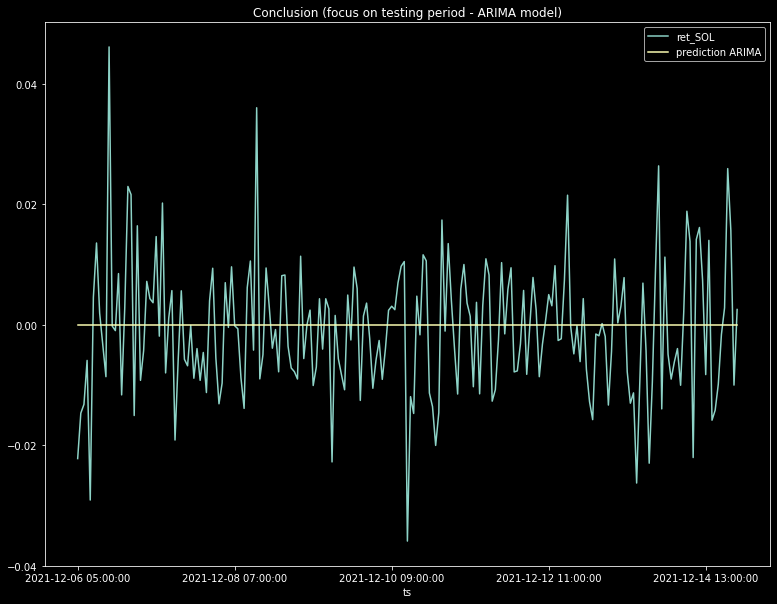

RMSE (without cross-validation) :0.011035348623633494


In [16]:
arima_model = arimamodel(y_train)
arima_model.summary()
pred = arima_model.predict(len(y_test))

df_conclu = pd.merge(pd.DataFrame(y), pd.DataFrame(pred, index = y_test.index, 
                                          columns = ['prediction ARIMA']), how = 'left',
                     left_index = True, right_index = True)
df_conclu.plot(figsize = (13,10))
plt.title('Conclusion (whole sample)')
plt.show()

df_conclu.loc[y_test.index].plot(figsize = (13,10))
plt.title('Conclusion (focus on testing period - ARIMA model)')
plt.show()

print('RMSE (without cross-validation) :'+str(rmse(pred, y_test.values)))

###### Thus, neither a basic AR model nor an ARIMA model seem to give relevant results - it seems not much more . Yet, I will now try to find seasonality in the data : if I do so, I will try to use a SARIMA model.

### 3. 3. looking for seasonality - SARIMA models ?

###### My idea here is that the returns migth vary depending on the weekday. 

In [17]:
df_check_saisonnality = pd.DataFrame(y_train).copy()
df_check_saisonnality = df_check_saisonnality.reset_index()

In [18]:
df_check_saisonnality.ts = pd.to_datetime(df_check_saisonnality.ts)
df_check_saisonnality['day'] = df_check_saisonnality.ts.dt.weekday

<AxesSubplot:title={'center':'std returns'}, xlabel='day'>

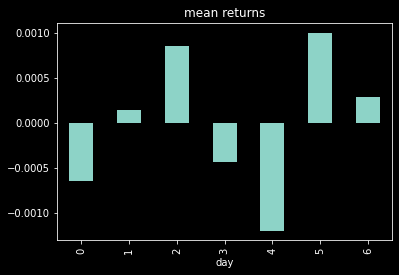

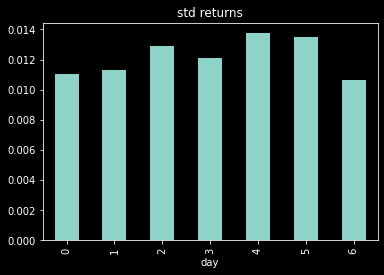

In [19]:
df_check_saisonnality[['ret_SOL','day']].groupby('day').mean().plot(kind = 'bar',title = 'mean returns',legend=False)
df_check_saisonnality[['ret_SOL','day']].groupby('day').std().plot(kind = 'bar', title = 'std returns',legend=False)

###### We will now assess whether the results are significatively differents depending on the day, using a t-test.

In [20]:
import scipy

In [21]:
List_returns_per_weekdays = [] # List of the returns for each weekday
table_weekdays = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                  4:'Friday',5:'Saturday',6:'Sunday'}
for i in range(7):
    List_returns_per_weekdays.append(df_check_saisonnality[df_check_saisonnality.day == i])
    
for i in range(7):
    for j in range(i+1,7):
        p_val = scipy.stats.ttest_ind(List_returns_per_weekdays[i]['ret_SOL'].values,
                                      List_returns_per_weekdays[j]['ret_SOL'].values)[1] 
        if p_val < 0.05: # if there is a significative difference in returns between the two weekdays
            print(str(table_weekdays[i])+' and '+str(table_weekdays[j])+'have a significative difference in returns')

###### We can not conclude that there is any evidence of seasonality. Therefore, a SARIMA method does not seem relevant.

## 4. Second model : regressive model

In [22]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.svm import SVC

In [23]:
Dic_crossval_RMSE = {}

# Get rid of the NaN to perform the test

Dic_crossval_RMSE['Rand_For'] = abs(evaluate_model(ensemble.RandomForestRegressor(), X, y))
Dic_crossval_RMSE['Lin_Reg'] = abs(evaluate_model(linear_model.LinearRegression(), X, y))
Dic_crossval_RMSE['Lasso_Lars'] = abs(evaluate_model(LassoLarsCV(), X, y))
Dic_crossval_RMSE['Grad_Boost'] = abs(evaluate_model(ensemble.GradientBoostingRegressor(), X, y))

In [24]:
df_crossval_RMSE = pd.DataFrame(Dic_crossval_RMSE.values(),Dic_crossval_RMSE.keys(), columns = ['Mean cross-validated RMSE'])

In [25]:
df_crossval_RMSE

,Mean cross-validated RMSE
Rand_For,0.008964
Lin_Reg,0.008595
Lasso_Lars,0.008572
Grad_Boost,0.008970


<Figure size 936x720 with 0 Axes>

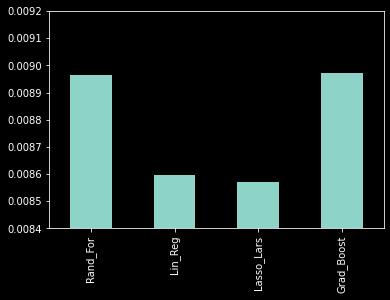

In [26]:
plt.figure(figsize = (13,10))
df_crossval_RMSE.plot(kind = 'bar', legend = False, ylim = [0.0084,0.0092])
plt.show()

###### We now focus on the Lasso_Lars method. We will first optimize its parameters, and then optimize the number of features to be taken into account ( see 2. ) 

----

In [27]:
LassoLarsCV().get_params().keys()

dict_keys(['copy_X', 'cv', 'eps', 'fit_intercept', 'max_iter', 'max_n_alphas', 'n_jobs', 'normalize', 'positive', 'precompute', 'verbose'])

In [28]:
parameters = [
  {'max_iter': [500, 800, 1000], 'max_n_alphas': [100,500,1000], 'cv' : [1,2,3,4,5,6,7,8,9,10]}
 ]
svc = LassoLarsCV()
clf = GridSearchCV(svc, parameters, scoring=None, refit=True)

clf.fit(X,y)

GridSearchCV(estimator=LassoLarsCV(),
             param_grid=[{'cv': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'max_iter': [500, 800, 1000],
                          'max_n_alphas': [100, 500, 1000]}])

In [29]:
clf.best_params_

{'cv': 10, 'max_iter': 500, 'max_n_alphas': 500}

In [30]:
clf.best_estimator_

LassoLarsCV(cv=10, max_n_alphas=500)

In [31]:
evaluate_model(LassoLarsCV(cv=10, max_n_alphas=500), X, y)

-0.008553496634823821

----

In [32]:
for n in range(1,10):
    restricted_features = X_train.columns[sort][-n:]
    X_bis = X[restricted_features].copy()
    print('Number of features :'+str(n))
    print(evaluate_model(LassoLarsCV(cv=10, max_n_alphas=500), X_bis, y))

Number of features :1
-0.008560907793703873
Number of features :2
-0.008556876509104881
Number of features :3
-0.008587260391762561
Number of features :4
-0.008581087334735522
Number of features :5
-0.008567980978729609
Number of features :6
-0.008569742749676756
Number of features :7
-0.008540127368217658
Number of features :8
-0.008527667674337793
Number of features :9
-0.008534568671348143


<Figure size 864x576 with 0 Axes>

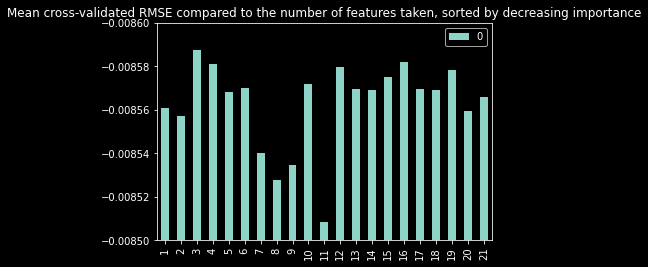

In [33]:
Plot_RMSE_linReg = {}
for n in range(1,22):
    restricted_features = X.columns[sort][-n:]
    X_bis = X[restricted_features].copy()
    Plot_RMSE_linReg[str(n)]=evaluate_model(LassoLarsCV(cv=10, max_n_alphas=500), X_bis[restricted_features], y)

plt.figure(figsize = (12,8))
Plot_RMSE_linReg = pd.DataFrame(Plot_RMSE_linReg.values(), Plot_RMSE_linReg.keys())
Plot_RMSE_linReg.plot(kind = 'bar',ylim = [-0.0085,-0.0086],
                      title = 'Mean cross-validated RMSE compared to the number of features taken, sorted by decreasing importance')
plt.show()

###### Let's try to consider the 11 most important features according to 2. . 

In [34]:
evaluate_model(LassoLarsCV(cv=10, max_n_alphas=500), X[X.columns[sort][-11:]], y)

-0.008508362055557012

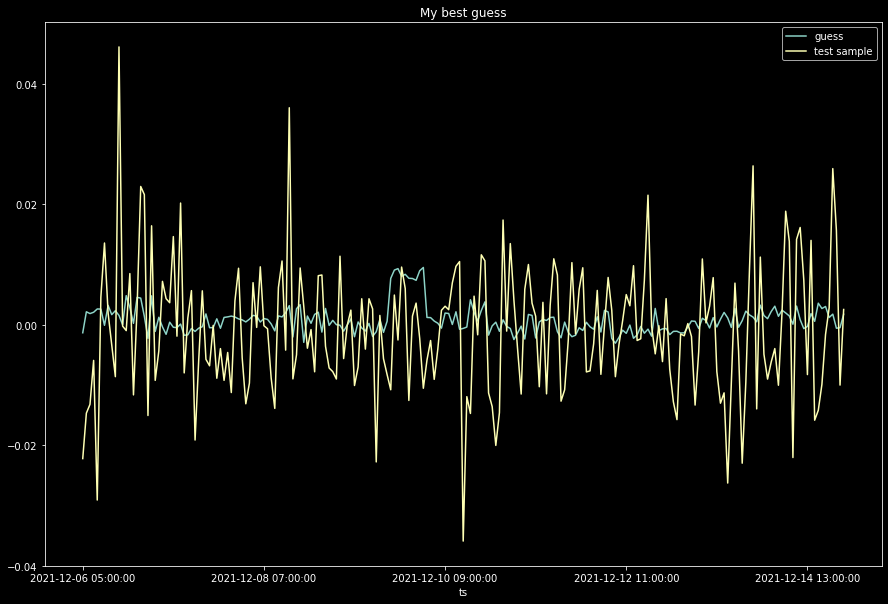

In [36]:
regressor = LassoLarsCV(cv=10, max_n_alphas=500)
regressor.fit(X_train[X.columns[sort][-11:]],y_train)
y_prediction = regressor.predict(X_test[X.columns[sort][-11:]])


df_conclu = pd.merge(pd.DataFrame(y_prediction, index = y_test.index, columns = ['guess']),y_test,
                     how='left',left_index=True,right_index=True)
df_conclu = df_conclu.rename(columns = 
                {'ret_SOL':'test sample'
                })
df_conclu.plot(figsize = (15,10), title = 'My best guess')
plt.show()

## Conclusion

- chosen model : LassoLarsCV(cv = 10, max_n_alphas = 500)
- features taken into account in the model :
    - 'vol_COMP', 'vol_ATOM', 'ret_BTC', 'ret_ETH', 'ret_DOT', 'ret_AAVE','ret_CRV', 'ret_AVAX', 'vol_SOL', 'ret_SOL', 'ret_ATOM'

I also tried to include this restriction on the in-class process (class_model_modified.py). However, it does not improve the results.